In [1]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [15]:
def jsonl_to_dataframe(file_path):
    #logging.info(f"Loading JSONL file from {file_path}...")
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            record = json.loads(line)
            if 'time_series' in record:
                time_series_data = record.pop('time_series')
                record.update(time_series_data)
            data.append(record)
    df = pd.DataFrame(data)
    
    #logging.info("Available columns in DataFrame: %s", df.columns)
    return df

def is_nested(column):
    return column.apply(lambda x: isinstance(x, (list, dict))).any()

# Function to apply PCA
def apply_pca(cluster_data, n_components=2):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(cluster_data)
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by each component: {explained_variance}")
    return principal_components

# Elbow method to take an axis for subplotting
def elbow_method(cluster_data, max_k=10, ax=None, title='Elbow Method'):
    distortions = []
    K = range(1, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(cluster_data)
        distortions.append(kmeans.inertia_)
    
    # Plot on the provided axis
    ax.plot(K, distortions, 'bx-')
    ax.set_xlabel('Number of clusters (k)')
    ax.set_ylabel('Distortion')
    ax.set_title(title)

    return distortions

# Applying elbow method on all four datasets and plotting them
def plot_elbow_methods(datasets, max_k=10, titles=None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, data in enumerate(datasets):
        title = titles[i] if titles else f'Dataset {i+1}'
        elbow_method(data, max_k=max_k, ax=axes[i], title=title)
    
    plt.tight_layout()
    plt.show()

# Function to apply k-means clustering and visualize results on PCA-transformed data
def kmeans_clustering(pca_transformed_data, n_clusters, titles):
    # Perform KMeans clustering on PCA-transformed data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pca_transformed_data)
    cluster_centers = kmeans.cluster_centers_
    silhouette_avg = silhouette_score(pca_transformed_data, labels)
 
    
    return labels, cluster_centers

# Function to apply Gaussian Mixture Model clustering
def gmm_clustering(pca_transformed_data, n_clusters):
    # Create and fit GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(pca_transformed_data)
    
    # Predict cluster labels
    labels = gmm.predict(pca_transformed_data)
    
    # Extract cluster centers
    cluster_centers = gmm.means_
    
    # Calculate silhouette score (optional)
    silhouette_avg = silhouette_score(pca_transformed_data, labels)
    
    return labels, cluster_centers

def gmm_clustering_with_pca_plot(pca_transformed_data, n_clusters, title="PCA Cluster Plot with GMM"):

    # Create and fit GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(pca_transformed_data)
    
    # Predict cluster labels
    labels = gmm.predict(pca_transformed_data)
    
    # Extract cluster centers
    cluster_centers = gmm.means_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(pca_transformed_data, labels)
    
    # Plot the clusters in PCA space
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        pca_transformed_data[:, 0], 
        pca_transformed_data[:, 1], 
        c=labels, cmap='viridis', s=50, alpha=0.8, label="Data Points"
    )
    plt.scatter(
        cluster_centers[:, 0], 
        cluster_centers[:, 1], 
        c='red', s=200, marker='X', label="Centroids"
    )
    plt.title(f'{title} (Silhouette: {silhouette_avg:.2f})', fontsize=16)
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    plt.colorbar(scatter, label='Cluster')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()
    
    return labels, cluster_centers, silhouette_avg


In [3]:
time_file_path = r'D:\MENG-Project\bearings-project-meng\Streamlit\outputs\Gold\time_domain_features.jsonl'
freq_file_path = r'D:\MENG-Project\bearings-project-meng\Streamlit\outputs\Gold\frequency_domain_features.jsonl'
hybrid_file_path = r'D:\MENG-Project\bearings-project-meng\Streamlit\outputs\Gold\time_frequency_features.jsonl'

data1 = jsonl_to_dataframe(time_file_path)
data2 = jsonl_to_dataframe(freq_file_path)
data3 = jsonl_to_dataframe(hybrid_file_path)

raw_data1 = data1.loc[:, ~data1.apply(is_nested)]
raw_data2 = data2.loc[:, ~data2.apply(is_nested)]
raw_data3 = data3.loc[:, ~data3.apply(is_nested)]

time_cluster = raw_data1.drop(columns=['identifier','timestamp','channel_x_anomalies','channel_y_anomalies'])
freq_cluster = raw_data2.drop(columns=['identifier','timestamp','channel_x_anomalies','channel_y_anomalies'])
hybrid_cluster = raw_data3.drop(columns=['identifier','timestamp','channel_x_anomalies','channel_y_anomalies'])

In [4]:
merge_data1 = raw_data1.merge(raw_data2, on = 'timestamp')
merge_data = merge_data1.merge(raw_data3, on = 'timestamp')
drop_substrings = ['identifier', 'timestamp', 'channel_x_anomalies', 'channel_y_anomalies']

# Drop columns containing any of the specified substrings
merge_cluster = merge_data.loc[:, ~merge_data.columns.str.contains('|'.join(drop_substrings))]



In [13]:
time_pca = apply_pca(time_cluster)
freq_pca = apply_pca(freq_cluster)
hybrid_pca = apply_pca(hybrid_cluster)
merge_pca = apply_pca(merge_cluster)

data_collection = [time_cluster,freq_cluster,hybrid_cluster,merge_cluster]

Explained variance by each component: [0.86039639 0.10004884]
Explained variance by each component: [0.75488689 0.24130556]
Explained variance by each component: [0.56230875 0.43566836]
Explained variance by each component: [0.73970047 0.23657366]


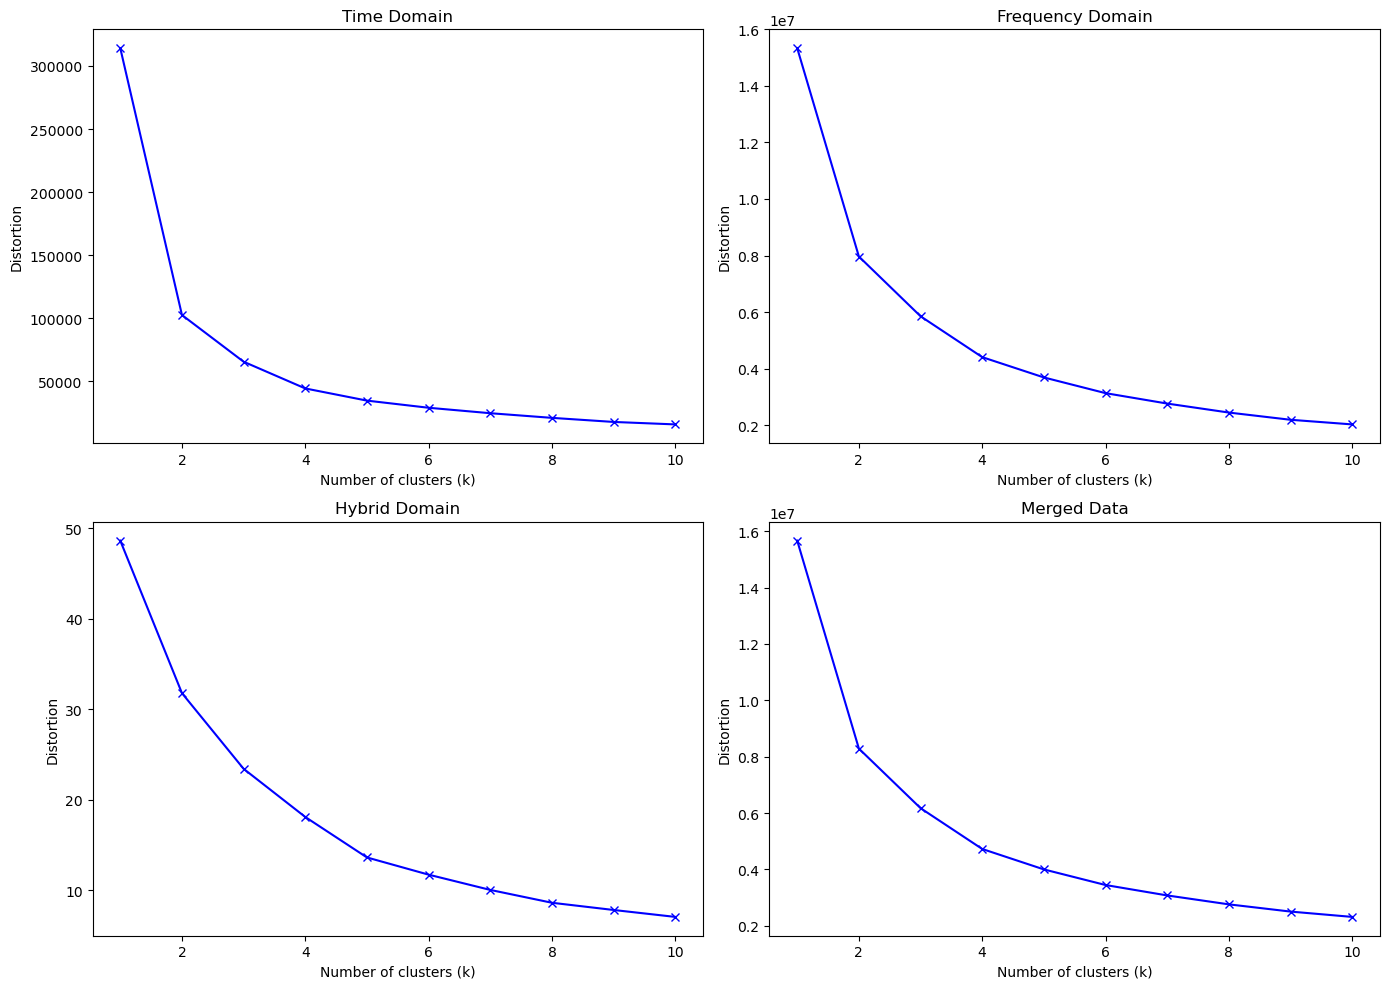

In [16]:
titles = ['Time Domain', 'Frequency Domain', 'Hybrid Domain', 'Merged Data']
plot_elbow_methods(data_collection, max_k=10, titles=titles)

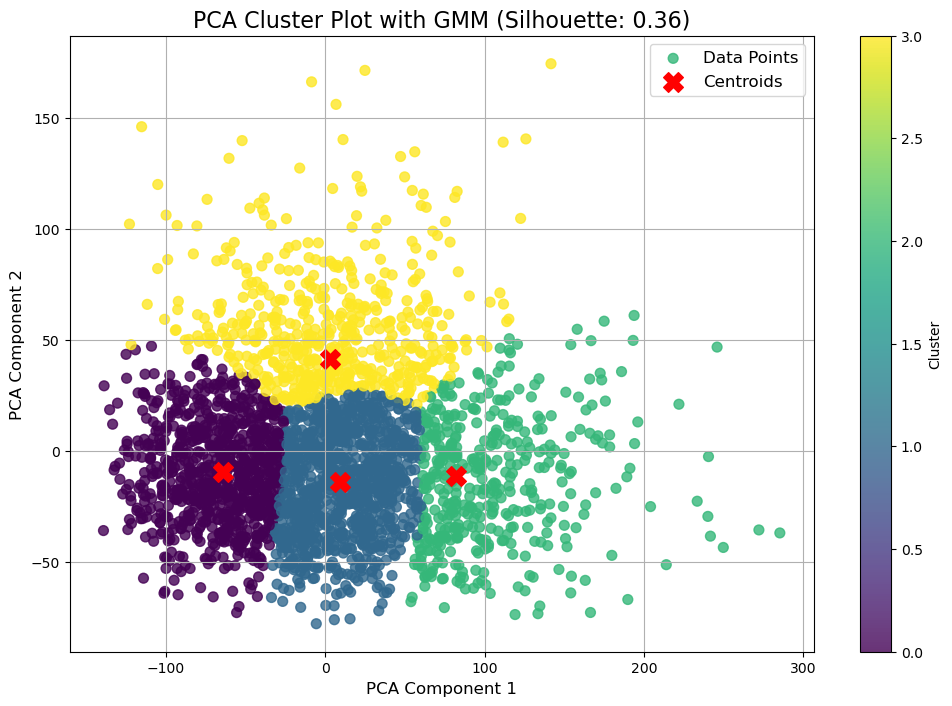

In [16]:
label , cluster, s_avg = gmm_clustering_with_pca_plot(freq_pca,4)

In [ ]:
optimal_k = [3,4,3,3]
result_label = []
result_cluster = []

for data,n_clusters in zip(data_collection,optimal_k):
    label , cluster = gmm_clustering(data, n_clusters)
    result_label.append(label)
    result_cluster.append(cluster)
    

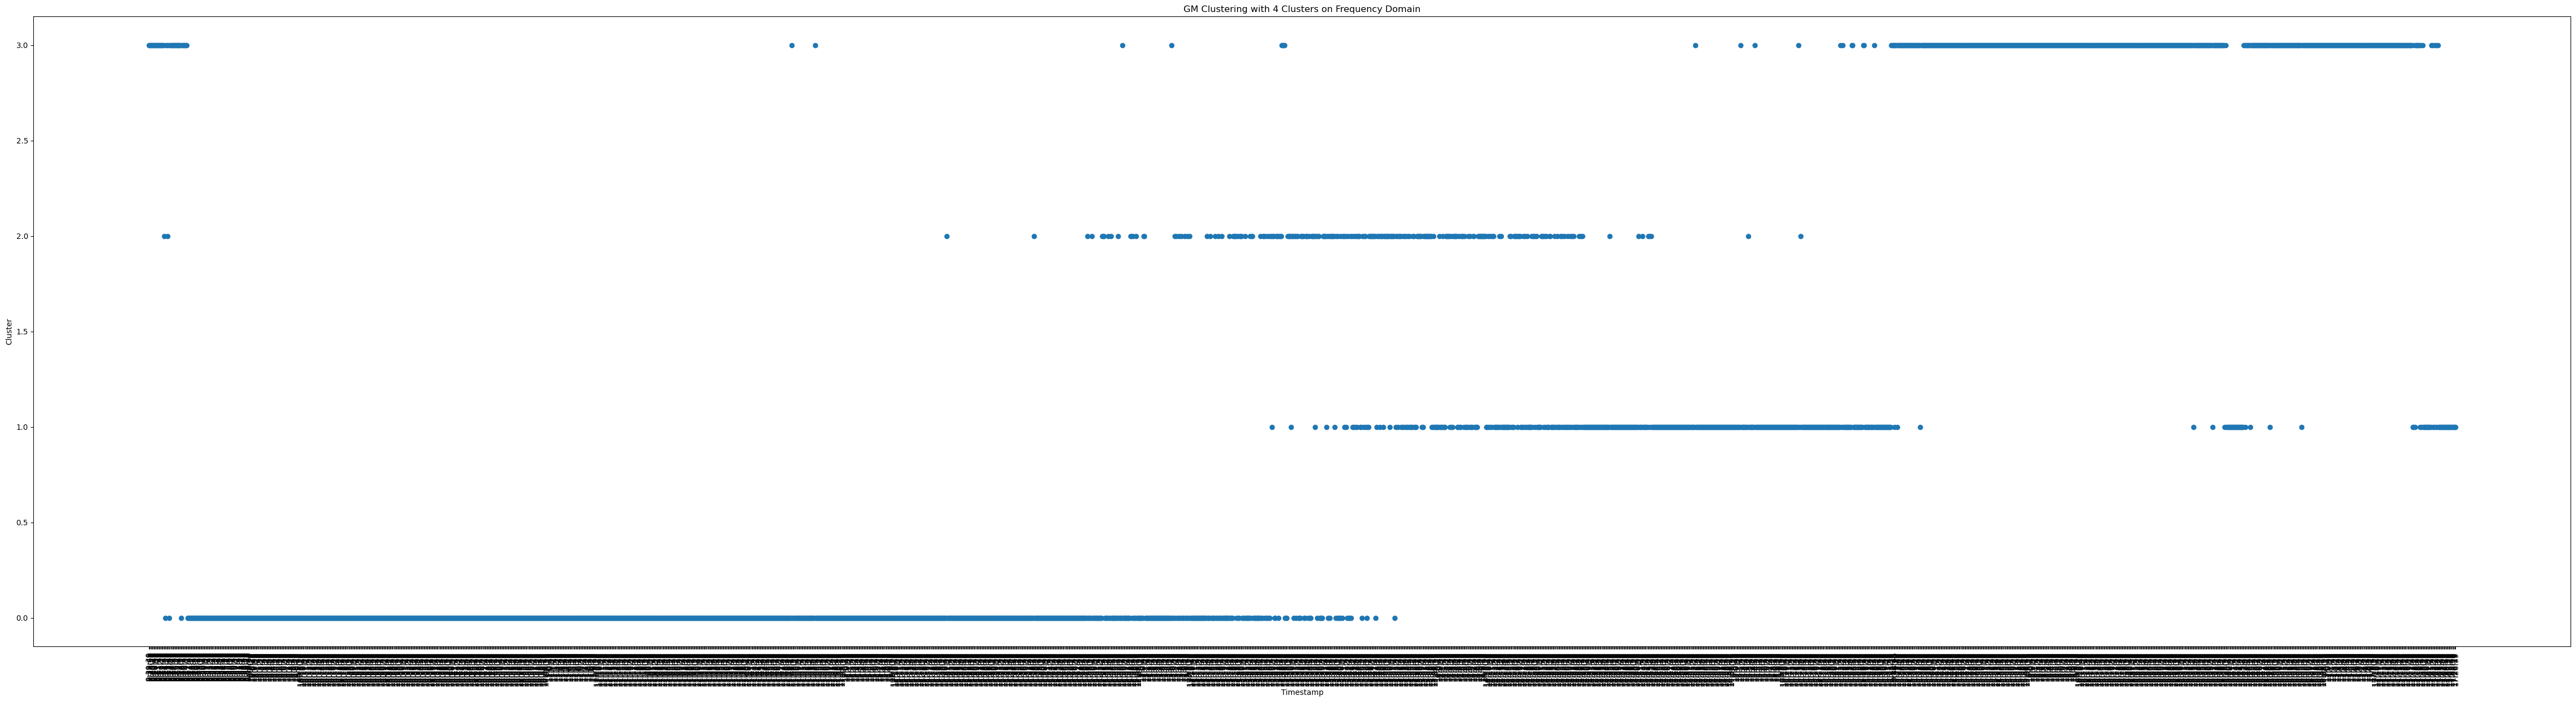

In [22]:
# Plot the clusters with timestamps
plt.figure(figsize=(60, 15))
scatter = plt.scatter(raw_data2['timestamp'], result_label[1])
plt.title(f'GM Clustering with 4 Clusters on {titles[1]}')
plt.xlabel('Timestamp')
plt.xticks(rotation = 90)
plt.ylabel('Cluster')
#plt.colorbar(scatter, label='Cluster')
#plt.grid(True)
plt.show()

In [23]:
# Create DataFrame for labels
df_labels = pd.DataFrame(result_label[1], columns=['label'])

# Merge the original data with the labels
res = raw_data2.merge(df_labels, left_index=True, right_index=True)

#res['timestamp'] = pd.to_datetime(res['timestamp'])

# Display the resulting DataFrame
print(res)

      identifier  bearing  split timestamp  channel_x_anomalies  \
0     Bearing1_1        0      0   9:39:39                 True   
1     Bearing1_1        0      0   9:39:49                 True   
2     Bearing1_1        0      0   9:39:59                 True   
3     Bearing1_1        0      0    9:40:9                 True   
4     Bearing1_1        0      0   9:40:19                 True   
...          ...      ...    ...       ...                  ...   
2798  Bearing1_1        0      0  17:25:59                 True   
2799  Bearing1_1        0      0   17:26:9                 True   
2800  Bearing1_1        0      0  17:26:19                 True   
2801  Bearing1_1        0      0  17:26:29                 True   
2802  Bearing1_1        0      0  17:26:39                 True   

      channel_y_anomalies  channel_x_fft_mean  channel_x_fft_std  \
0                    True           29.505197          41.101061   
1                    True           30.854258          40.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


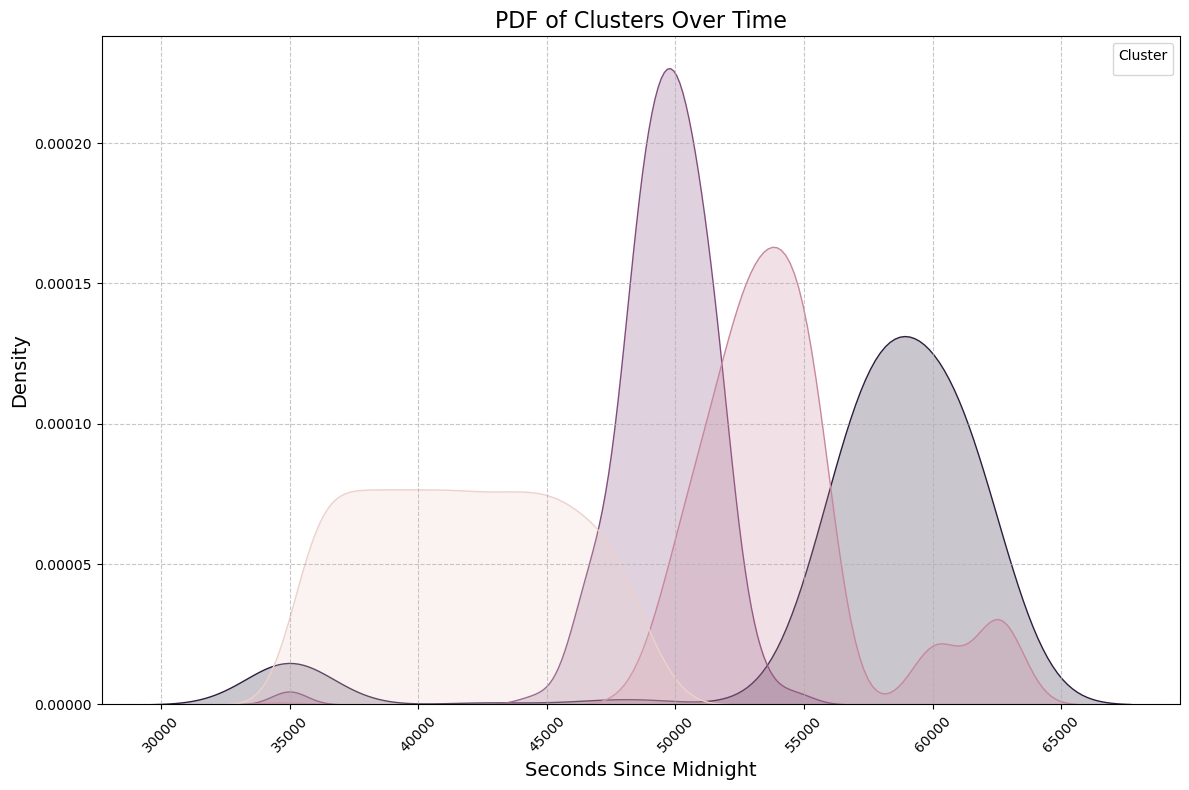

In [24]:
# Convert timestamps to seconds since midnight
res['timestamp_seconds'] = pd.to_timedelta(res['timestamp']).dt.total_seconds()

# Create a KDE plot for each cluster
plt.figure(figsize=(12, 8))
sns.kdeplot(data=res, x="timestamp_seconds", hue="label", common_norm=False, fill=True)

# Format the plot
plt.title("PDF of Clusters Over Time", fontsize=16)
plt.xlabel("Seconds Since Midnight", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


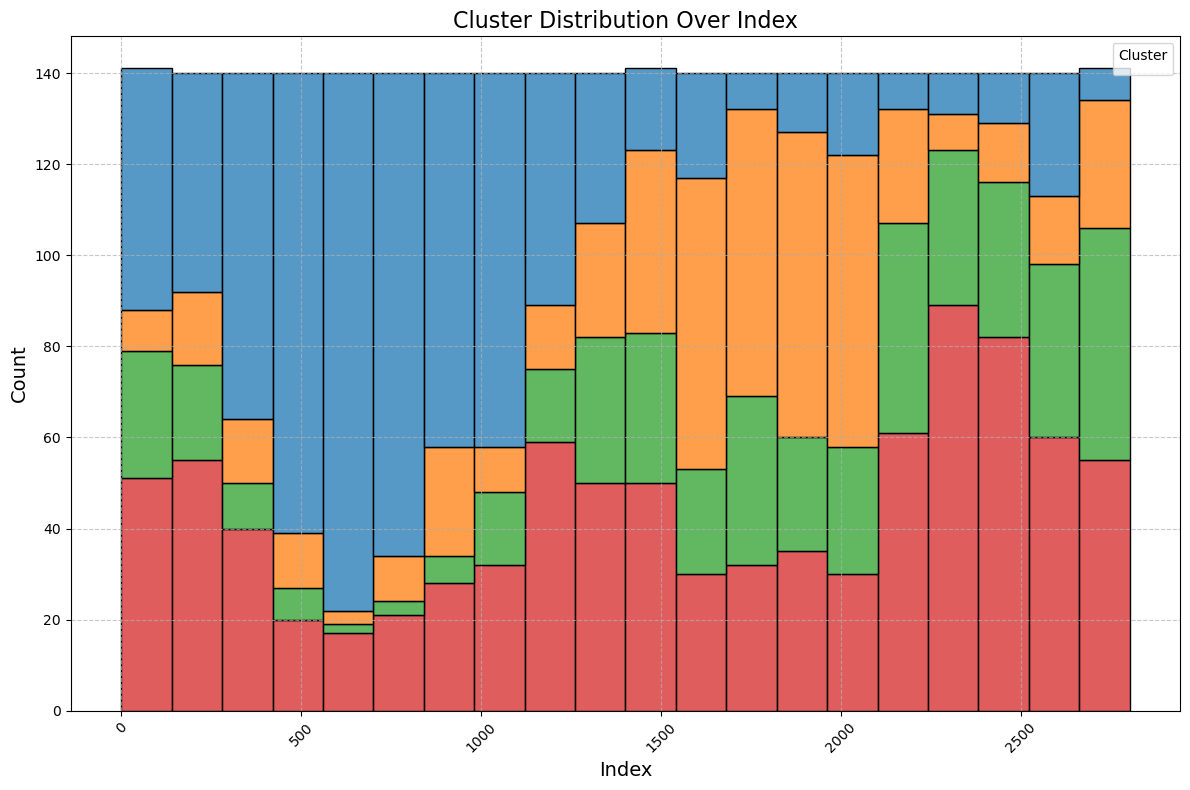

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram plot to show cluster distributions
plt.figure(figsize=(12, 8))
sns.histplot(data=res, x=res.index, hue="label", multiple="stack", bins=20, kde=False)

# Format the plot
plt.title("Cluster Distribution Over Index", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


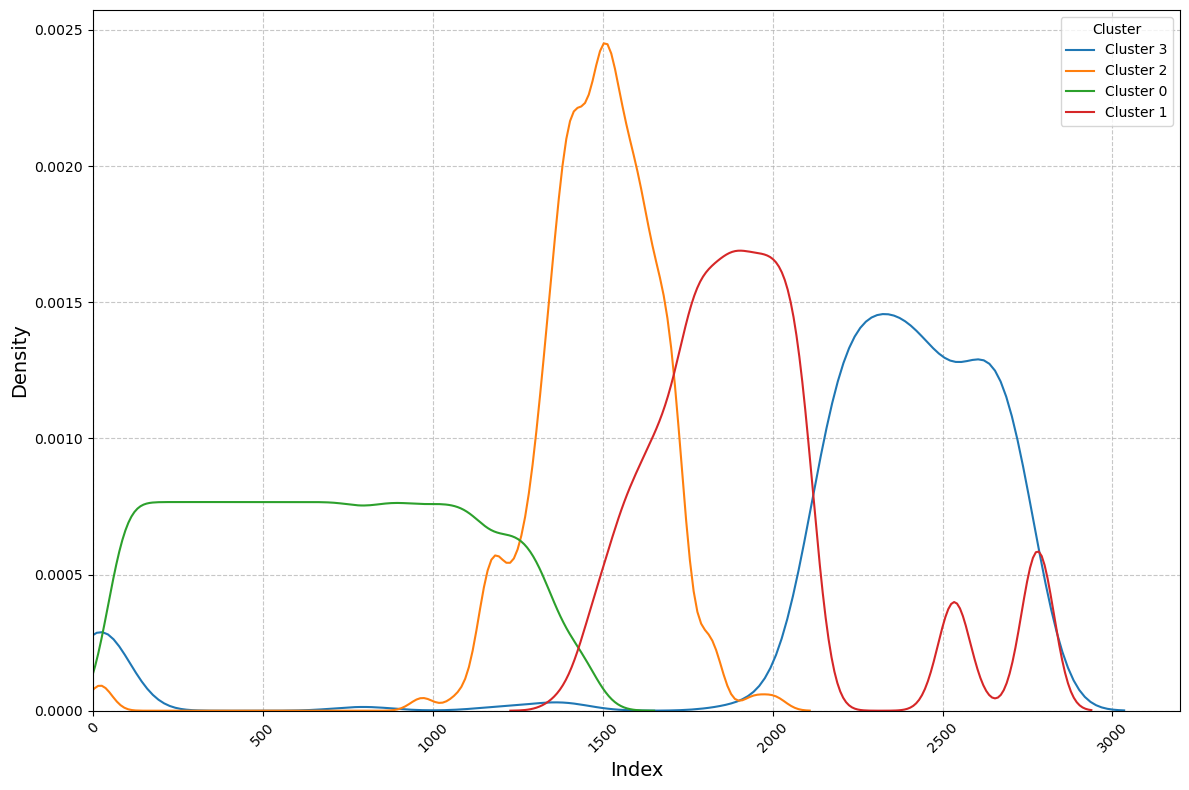

In [25]:
# Create a numerical representation of the index
res['index_numeric'] = res.index.astype(float)

# Calculate PDFs for each cluster
plt.figure(figsize=(12, 8))
for label in res['label'].unique():
    subset = res[res['label'] == label]
    sns.kdeplot(
        data=subset, 
        x="index_numeric", 
        label=f"Cluster {label}", 
        fill=False, 
        bw_adjust=0.5
    )

# Format the plot
#plt.title("PDF of Clusters Over Index (Line Plot)", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.xlim(0)
plt.ylabel("Density", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()